In [6]:
# import libraries
#import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [7]:
import gzip
import pickle
import os
from urllib.request import urlretrieve
import numpy as np
from matplotlib import image

def mnist(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.

    url = 'http://yann.lecun.com/exdb/mnist/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']
    """
    if path is None:
        # Set path to /home/USER/data/mnist or C:\Users\USER\data\salt
        path = os.path.join(os.path.expanduser('~/'), 'data', 'salt2')

    # Create path if it doesn't exist
    #os.makedirs(path, exist_ok=True)
    """"
    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))
    print("All files are ready to gzip!")
    """
    dim=64
    dataset=4
    def _images(path,dim):
        """Return images loaded locally."""
        folder = path + "/images/"
        onlyfiles = [cv2.resize(cv2.cvtColor(image.imread(folder+f), cv2.COLOR_RGB2GRAY),(dim, dim)) for f in os.listdir(folder)]
        pixels = np.array(onlyfiles).reshape(-1,1,dim,dim).astype('float32')#/255
        return pixels[:dataset,:,:,:]

    def _labels(path,dim):
        """Return labels loaded locally."""
        
        folder = path + "/labels/"
        #onlyfiles = [cv2.resize(cv2.cvtColor(image.imread(folder+f), cv2.COLOR_RGB2GRAY),(dim, dim)) for f in os.listdir(folder)]
        onlyfiles = [cv2.resize(image.imread(folder+f),(dim, dim)) for f in os.listdir(folder)]
        pixels = np.array(onlyfiles).reshape(-1,1,dim,dim).astype('float32') #/255
        return pixels[:dataset,:,:,:]
    
    def _t_images(path,dim):
        """Return images loaded locally."""
        folder = path + "/t_images/"
        onlyfiles = [cv2.resize(cv2.cvtColor(image.imread(folder+f), cv2.COLOR_RGB2GRAY),(dim, dim)) for f in os.listdir(folder)]
        pixels = np.array(onlyfiles).reshape(-1,1,dim,dim).astype('float32')#/255
        return pixels[0:2,:,:,:]
    def _t_labels(path,dim):
        """Return labels loaded locally."""
        
        folder = path + "/t_labels/"
        onlyfiles = [cv2.resize(cv2.cvtColor(image.imread(folder+f), cv2.COLOR_RGB2GRAY),(dim, dim)) for f in os.listdir(folder)]
        #onlyfiles = [cv2.resize(image.imread(folder+f),(32, 32)) for f in os.listdir(folder)]
        pixels = np.array(onlyfiles).reshape(-1,1,dim,dim).astype('float32') #/255
        return pixels[0:2,:,:,:]

    print("Train Images : Loading . . .")
    train_images = _images(path,dim)
    print("Train Labels : Loading . . .")
    train_labels = _labels(path,dim)
    print("Test Images  : Loading . . .")
    #test_images = _t_images(path,dim)
    print("Test Labels  : Loading . . .")
    #test_labels = _t_labels(path,dim)
    print("Done!")
    return train_images, train_labels# , test_images, test_labels

In [8]:
train_images, train_labels= mnist()  #, test_images, test_labels 

Train Images : Loading . . .
Train Labels : Loading . . .
Test Images  : Loading . . .
Test Labels  : Loading . . .
Done!


In [9]:
ch = 1 #Number of channels
print(train_images.shape)
print(train_labels.shape) # ONE-HOT !!!
#print(train_images.T.shape)
#print(train_labels.reshape((train_images.shape[0], 10)).shape)

##### Getting Ready for the Conv Layers #####
#train_images = train_images.reshape(train_images.shape[0], ch, 28, 28).squeeze()
#test_images = test_images.reshape(test_images.shape[0], ch, 28, 28).squeeze()

#############################################

#y = train_images[1].reshape(1,28,28)
#print(y.squeeze().shape)
'''
temp = []
#train_labels = train_labels.sum(1)
for i in range(int(len(train_labels[:]))):
    temp.append(list(train_labels[i][:]).index(1))
    
    
train_labels = np.array(temp.copy())
#print(train_labels[0:5])
'''
#plt.imshow(train_images[0].squeeze(), cmap='Greys_r');
pass

(4, 1, 64, 64)
(4, 1, 64, 64)


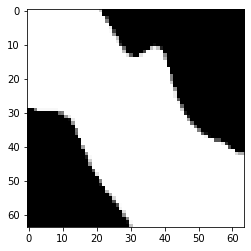

In [10]:
plt.imshow(train_labels[0].squeeze(), cmap='Greys_r');


In [8]:
plt.imshow(test_images[0].squeeze(), cmap='Greys_r');

NameError: name 'test_images' is not defined

In [11]:
############### Filter/Parameter Initializattions  ##################

def init_filters(layers, init_n_f ,trim):
    filters = []
    bias = []
    f_dc = []
    
    trimf = trim
    trimb = trim*5
    n_f = init_n_f #initial number of filters/kernels
    ch_in = 1      #input channels
    """
    for i in range(layers):
        if(i != 0):
            n_f = n_f*2 #16,32,64,128,256
        #f1 shape : (num_filters,input channels, f_h, f_w)
        f1 = (n_f, ch_in, 3, 3)
        f1 = np.random.randn(n_f, ch_in, 3, 3) *trimf
        b1 = np.random.randn(f1.shape[0],1)* trimb
        ch_in = n_f
        f2 = (n_f, ch_in, 3, 3)
        f2 = np.random.randn(n_f, ch_in, 3, 3) *trimf
        b2 = np.random.randn(f2.shape[0],1)* trimb
        f = [f1, f2]
        b = [b1, b2]
        filters.append(f)
        bias.append(b)
    
    #Deconvolution filters    
    for i in range(1,layers):
        n_f = n_f//2 #128,64,32,16
        #f1 shape : (num_filters,input channels, f_h, f_w)
        fdc = np.random.randn(n_f,ch_in,2,2)*trimf #upsampling filter, its result will be conc with conv4 output so the channels will be doubled again
        bdc = np.random.randn(fdc.shape[0],1)* trimb
        f1 = (n_f, ch_in, 3, 3)
        f1 = np.random.randn(n_f, ch_in, 3, 3) *trimf
        b1 = np.random.randn(f1.shape[0],1)* trimb
        ch_in = n_f
        f2 = (n_f, ch_in, 3, 3)
        f2 = np.random.randn(n_f, ch_in, 3, 3) *trimf
        b2 = np.random.randn(f2.shape[0],1)* trimb
        f = [f1, f2]
        b = [b1, b2]
        dc = [fdc, bdc]
        filters.append(f)
        bias.append(b)
        f_dc.append(dc)
        
    """
    trimbr = trim
    locbr = 0
    scb=1
    for i in range(layers):
        if(i != 0):
            n_f = n_f*2 #16,32,64,128,256
        #f1 shape : (num_filters,input channels, f_h, f_w)
        f1 = (n_f, ch_in, 3, 3)
        f1 = np.random.normal(loc = locbr, scale = trimbr , size = f1) #np.random.randn(n_f, ch_in, 3, 3) *trimf
        b1 = np.random.normal(loc = locbr, scale = trimbr*scb , size = (f1.shape[0],1)) #np.random.randn(f1.shape[0],1)* trimb
        ch_in = n_f
        f2 = (n_f, ch_in, 3, 3)
        f2 = np.random.normal(loc = locbr, scale = trimbr , size = f2)
        b2 = np.random.normal(loc = locbr, scale = trimbr*scb, size = (f2.shape[0],1))
        f = [f1, f2]
        b = [b1, b2]
        filters.append(f)
        bias.append(b)
    
    #Deconvolution filters    
    for i in range(1,layers):
        n_f = n_f//2 #128,64,32,16
        #f1 shape : (num_filters,input channels, f_h, f_w)
        fdc =  np.random.normal(loc = locbr, scale = trimbr , size = (n_f,ch_in,2,2))#upsampling filter, its result will be conc with conv4 output so the channels will be doubled again
        bdc = np.random.normal(loc = locbr, scale = trimbr*scb , size = (fdc.shape[0],1))
        f1 = (n_f, ch_in, 3, 3)
        f1 = np.random.normal(loc = locbr, scale = trimbr , size = (n_f, ch_in, 3, 3))
        b1 = np.random.normal(loc = locbr, scale = trimbr*scb , size = (f1.shape[0],1))
        ch_in = n_f
        f2 = (n_f, ch_in, 3, 3)
        f2 = np.random.normal(loc = locbr, scale = trimbr , size = f2)
        b2 = np.random.normal(loc = locbr, scale = trimbr*scb , size = (f2.shape[0],1))
        f = [f1, f2]
        b = [b1, b2]
        dc = [fdc, bdc]
        filters.append(f)
        bias.append(b)
        f_dc.append(dc)
    return filters, bias, f_dc   


def init_groupnorm_params(bias, out_b, norm_batch, locbr, trimbr):
    [b1,b2,b3,b4,b5,b6,b7,b8,b9]= bias 
    
    
    t_1,_ = b1
    gb_size =(t_1.shape[0]//norm_batch,1)
    gamma1_1 = np.random.normal(loc = locbr, scale = trimbr , size = gb_size) #MAKE IT FLOAT
    beta1_1  = np.random.normal( scale = trimbr , size = gb_size)
    gamma1_2 = np.random.normal(loc = locbr, scale = trimbr , size = gb_size) 
    beta1_2  = np.random.normal( scale = trimbr , size = gb_size)
    tempg_1 = [gamma1_1,gamma1_2]
    tempb_1 = [beta1_1,beta1_2]
    
    t_1,_ = b2
    gb_size =(t_1.shape[0]//norm_batch,1)
    gamma2_1 = np.random.normal(loc = locbr, scale = trimbr , size = gb_size) 
    beta2_1  = np.random.normal( scale = trimbr , size = gb_size)
    gamma2_2 = np.random.normal(loc = locbr, scale = trimbr , size = gb_size) 
    beta2_2  = np.random.normal(scale = trimbr , size = gb_size)  
    tempg_2 = [gamma2_1,gamma2_2]
    tempb_2 = [beta2_1,beta2_2]
    
    t_1,_ = b3
    gb_size =(t_1.shape[0]//norm_batch,1)
    gamma3_1 = np.random.normal(loc = locbr, scale = trimbr , size = gb_size) 
    beta3_1  = np.random.normal(scale = trimbr , size = gb_size)
    gamma3_2 = np.random.normal(loc = locbr, scale = trimbr , size = gb_size) 
    beta3_2  = np.random.normal(scale = trimbr ,size =  gb_size)  
    tempg_3 = [gamma3_1,gamma3_2]
    tempb_3 = [beta3_1,beta3_2]
    
    t_1,_ = b4
    gb_size =(t_1.shape[0]//norm_batch,1)
    gamma4_1 = np.random.normal(loc = locbr, scale = trimbr , size = gb_size) 
    beta4_1  = np.random.normal(scale = trimbr , size = gb_size)
    gamma4_2 = np.random.normal(loc = locbr, scale = trimbr , size = gb_size) 
    beta4_2  = np.random.normal(scale = trimbr ,size =  gb_size)  
    tempg_4 = [gamma4_1,gamma4_2]
    tempb_4 = [beta4_1,beta4_2]
    
    t_1,_ = b5
    gb_size =(t_1.shape[0]//norm_batch,1)
    gamma5_1 = np.random.normal(loc = locbr, scale = trimbr , size = gb_size) 
    beta5_1  = np.random.normal(scale = trimbr , size = gb_size)
    gamma5_2 = np.random.normal(loc = locbr, scale = trimbr , size = gb_size) 
    beta5_2  = np.random.normal(scale = trimbr ,size =  gb_size)  
    tempg_5 = [gamma5_1,gamma5_2]
    tempb_5 = [beta5_1,beta5_2]
    
    t_1,_ = b6
    gb_size =(t_1.shape[0]//norm_batch,1)
    gamma6_1 = np.random.normal(loc = locbr, scale = trimbr , size = gb_size) 
    beta6_1  = np.random.normal(scale = trimbr , size = gb_size)
    gamma6_2 = np.random.normal(loc = locbr, scale = trimbr , size = gb_size) 
    beta6_2  = np.random.normal(scale = trimbr ,size =  gb_size)  
    tempg_6 = [gamma6_1,gamma6_2]
    tempb_6 = [beta6_1,beta6_2]
    
    t_1,_ = b7
    gb_size =(t_1.shape[0]//norm_batch,1)
    gamma7_1 = np.random.normal(loc = locbr, scale = trimbr , size = gb_size) 
    beta7_1  = np.random.normal(scale = trimbr , size = gb_size)
    gamma7_2 = np.random.normal(loc = locbr, scale = trimbr , size = gb_size) 
    beta7_2  = np.random.normal(scale = trimbr ,size =  gb_size)  
    tempg_7 = [gamma7_1,gamma7_2]
    tempb_7 = [beta7_1,beta7_2]
    
    t_1,_ = b8
    gb_size =(t_1.shape[0]//norm_batch,1)
    gamma8_1 = np.random.normal(loc = locbr, scale = trimbr , size = gb_size) 
    beta8_1  = np.random.normal(scale = trimbr , size = gb_size)
    gamma8_2 = np.random.normal(loc = locbr, scale = trimbr , size = gb_size) 
    beta8_2  = np.random.normal(scale = trimbr ,size =  gb_size)  
    tempg_8 = [gamma8_1,gamma8_2]
    tempb_8 = [beta8_1,beta8_2]
    
    t_1,_ = b9
    gb_size =(t_1.shape[0]//norm_batch,1)
    gamma9_1 = np.random.normal(loc = locbr, scale = trimbr , size = gb_size) 
    beta9_1  = np.random.normal(scale = trimbr , size = gb_size)
    gamma9_2 = np.random.normal(loc = locbr, scale = trimbr , size = gb_size) 
    beta9_2  = np.random.normal(scale = trimbr ,size =  gb_size)  
    tempg_9 = [gamma9_1,gamma9_2]
    tempb_9 = [beta9_1,beta9_2]
    
    ga =[tempg_1,tempg_2,tempg_3,tempg_4,tempg_5,tempg_6, tempg_7,tempg_8,tempg_9]
    be =[tempb_1,tempb_2,tempb_3,tempb_4,tempb_5,tempb_6, tempb_7,tempb_8,tempb_9]
    
    #gamma_out = np.random.normal(loc = locbr, scale = trimbr , size = (out_b.shape[0]//norm_batch,1))
    #beta_out =   np.random.normal(scale = trimbr , size = (out_b.shape[0]//norm_batch,1))
    
    return ga, be

In [12]:
### Activation Functions ###
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

In [13]:
########## UTILITIES #############

def conv(image, params, s = 1, pad = 1 ): # s = 1 (conv stride)
    #f1 shape : (num_filters,input channels, f_h, f_w)
    #image shape: (channels, height, width)
    [f, b] = params
    if(pad >= 1):
        tmp = np.zeros((image.shape[0],image.shape[1]+2*pad ,image.shape[2]+2*pad))
        tmp[:,pad:-pad,pad:-pad] = image
        image = tmp    
        
    f_num = f.shape[0]
    f_depth = f.shape[1] #f1 = 1 , f2 = 8
    f_size = f.shape[2] 
        

    h_range = int((image.shape[1] - f_size) / s) + 1     # (W - F + 2P) / S  
    w_range = int((image.shape[2] - f_size) / s) + 1     # (W - F + 2P) / S  
    np_o = np.zeros((f_num, h_range, w_range))
    for z in range(f_num): # Number of filters
        for _h in range(h_range):      
            for _w in range(w_range):
                np_o[z, _h, _w] = np.sum(np.multiply(image[:, _h*s : _h*s + f_size, _w*s : _w*s + f_size] , f[z, :, :, :])) + b[z]
    
    return np_o

def convolutionBackward(dconv_prev, conv_in, filt, s = 1, pad = 1 ):
    #filt =np.rot90(filt, 2)  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!! A T T E N T I O N !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    f_num, n_c, f, _ = filt.shape
    
    _ ,h , w = dconv_prev.shape
    dfilt = np.zeros(filt.shape)
    if(pad >= 1):
        tmp = np.zeros((conv_in.shape[0],conv_in.shape[1]+2*pad ,conv_in.shape[2]+2*pad))
        tmp[:,pad:-pad,pad:-pad] = conv_in
        conv_in = tmp
    
    dconv_in = np.zeros(conv_in.shape)
    db = np.zeros((f_num,1))

    for z in range(f_num): # Number of filters
        for _h in range(h):      
            for _w in range(w):
                #each entry of the dconv_prev will try to affect the idxs from which was made of.
                dfilt[z] += dconv_prev[z, _h, _w] * conv_in[:, _h*s : _h*s + f, _w*s : _w*s + f]
                dconv_in[:, _h*s : _h*s + f, _w*s : _w*s + f] += dconv_prev[z, _h, _w] * filt[z]  
        db[z] = np.sum(dconv_prev[z])  #, axis =1) ## AXIS?
    
    if(pad >=1 ):
        dconv_in = dconv_in[:, pad:-pad, pad:-pad]  # Cropping
        
    return dconv_in, dfilt, db

def convTransp1(image, params, s = 2, pad = 1):
    [f, b] = params
    n_f, n_c, f_s, _ = f.shape
    input_s = image.shape[1]
    target_dim = input_s*2
    res = np.zeros((n_f, target_dim, target_dim))
    temp =np.zeros((n_c, target_dim, target_dim))
    for z in range(n_f):
        for _h in range(input_s):      
            for _w in range(input_s):
                temp[:, _h*s:_h*s+f_s, _w*s:_w*s+f_s] += image[:, _h, _w].reshape(n_c,1,1)*f[z,:,:,:] #bias will be added at the end
        res[z] = np.sum(temp , axis = 0) + b[z]
    return res, image

def convTranspBackward1(dconv_prev, new_in, filt, s = 2):
    n_f, n_c, f_s, _ = filt.shape
    _, input_s, _ = new_in.shape
    #final_dim = (new_in.shape[1] - 2)//2 + 1 
    dc_s=dconv_prev.shape[1]
    temp = np.zeros((n_c,dc_s,dc_s))
    dfilt = np.zeros(filt.shape)
    dconv_in = np.zeros(new_in.shape)
    db = np.zeros((n_f,1))
    for z in range(n_f):
        for _h in range(input_s):      
            for _w in range(input_s): 
                dfilt[z] += dconv_prev[z, _h*s:_h*s+f_s, _w*s:_w*s+f_s]*new_in[:,_h,_w].reshape(n_c,1,1)
                temp[:, _h*s:_h*s+f_s, _w*s:_w*s+f_s] += dconv_prev[z, _h*s:_h*s+f_s, _w*s:_w*s+f_s] * filt[z]
                for ch in range(n_c):
                    dconv_in[ch, _h, _w] += np.sum(temp[ch, _h*s:_h*s+f_s, _w*s:_w*s+f_s])
        db[z] = np.sum(dconv_prev[z])        
    return dconv_in, dfilt, db

    
def convTransp(image, params, s = 1, pad = 1):
    #s is always 1, upsample kernel = 2
    #zero insertions between pixels s_downsampled -1 = 2-1 = 1
    #required padding in order to double my dimensions with the given data:
    #(i-1)*2 + k -2p = output size, where our padding is k - p -1 = 2-0-1=1(we assume p=0)
    [f, b]=params
    f = np.rot90(f, 2, (2,3))
    params = [f, b]
    input_s = image.shape[1]
    target_dim = input_s*2 #final dim, after conv
    required_pad = 1 #always for filter 2x2 ,stride 1, zero insertion 1 and main target to double dim
    #make our new custom input
    size = input_s*2 +1
    new_in = np.zeros((image.shape[0], size, size))
    
    ### OR just: np.pad(image[:,:,:],2,'constant') # Important, we must loop with respect to the 1st dim
    for i in range(1, target_dim, 2):
        for j in range(1, target_dim, 2):
                new_in[:, i, j] = image[:, i//2, j//2]
    #now we do a normal convolution(pad = 0)
    res = conv(new_in, params, 1, 0) #thats the final result with target_dim
    return res, new_in # we will need new_in so we wont calc it again for the backprop
    
def convTranspBackward(dconv_prev, new_in, filt, s = 1):
    #First, we do a backward convolution on new_in,d_conv_prev,
    #then we will choose form the d_conv_new the entries that match the initial 'smaller' input image
    #by selecting the odd matrix cells 1,3,5... because we had applied a standard pad=1,zero inser=1
    #filt = np.rot90(filt, 2, (2,3))
    dconv_in, dfilt, db = convolutionBackward(dconv_prev, new_in, filt,1,0)
    #Now its time to choose the right entries to build the gradients of the initial input image
    dim = dconv_in.shape[1]
    final_dim = (new_in.shape[1] - 2)//2 + 1 #based on dimen of image before final conv that gives the result,..
    #e.g. for new_in 7x7 that is going to convoluted with a 2x2 kernel and give a 6x6 upsampled from 3x3 init image
    # now from this 7x7 --> apply the formula above,we get the 3x3 dimension number
    res = np.zeros((dconv_in.shape[0], final_dim, final_dim))
    for i in range(1, dim, 2):
        for j in range(1, dim, 2):
                res[:, i//2, j//2] = dconv_in[:, i, j]
    return res, dfilt, db
    
    
def maxpool(image, f=2 , s=2):
    
    h_range = int((image.shape[1] - f) / s) + 1     # (W - F + 2P) / S  
    w_range = int((image.shape[2] - f) / s) + 1     # (W - F + 2P) / S 
    out = np.zeros((image.shape[0], h_range, w_range))
    
    for z in range(image.shape[0]): # Number of channels
        for _h in range(h_range):      
            for _w in range(w_range):
                out[z, _h, _w] = np.max(image[z, _h*s : _h*s + f, _w*s : _w*s + f])
    return out

def nanargmax(arr):

    idx = np.nanargmax(arr)
    idxs = np.unravel_index(idx, arr.shape)
    return idxs 

def maxpoolBackward(dpool, conv, f=2 , s=2):
    num_c, h, w = conv.shape
    h = int((h - f) / s) + 1     # (W - F + 2P) / S  
    w = int((w - f) / s) + 1     # (W - F + 2P) / S 
    
    dout = np.zeros(conv.shape)
    #print(conv.shape)
    for z in range(num_c): # Number of channels
        for _h in range(h):      
            for _w in range(w):
                (a, b) = nanargmax(conv[z, _h*s : _h*s + f, _w*s : _w*s + f]) #Getting the indexes from the max value in this area
                #put it on the new array
                dout[z, _h*s + a, _w*s + b] = dpool[z, _h, _w]
    
    
    return dout


def reshape(img, reshape_dim):
    pad = reshape_dim - img.shape[1]
    if(pad == 0):
        return img
    res = np.zeros((img.shape[0], reshape_dim, reshape_dim))
    if(pad > 1):
        res[:, pad//2:-(pad//2), pad//2:-(pad//2)] = img
    else:
        res[:, 0:-(pad), 0:-(pad)] = img
    return res


def crop(img, crop_dim): #TODO : look at it..future upgrade to downsample..maybe
    start = img.shape[1]//2 - crop_dim//2
    return img[:,(start):(start +crop_dim),(start):(start +crop_dim)]

    
    
def crop2half(img):
    #return gradients for decoder side and gradients for encoder side
    n_ch = img.shape[0]//2
    return img[n_ch:n_ch*2 ,:,:], img[0:n_ch,:,:]
    
def concat(img1_true, img2):
    n_ch = img1_true.shape[0]
    dim = img1_true.shape[1]
    if(img2.shape[1] != dim):
        img2 = crop(img2, dim)
        print("Warning: Extra crop needed and handled!(%d --> %d)" %(dim, img2.shape[1]))
    res = np.zeros((n_ch*2, dim, dim))
    res[0:n_ch,:,:] = img2
    res[n_ch:n_ch*2 ,:,:] = img1_true
    return res



In [14]:
###### Cost Calculations ######
def Cross_Entropy(logs, targets):  # Pixel-Wise Cross entropy --> average accuracy
    out = np.zeros(logs.shape)
    mylen = logs.shape[0]*logs.shape[1]*logs.shape[2]
    #print(len(targets))
    #logs.shape (dim x dim) like target
    for i in range(logs.shape[1]):
        for j in range(logs.shape[2]):
            if(targets[:,i,j] >= logs[:,i,j]):#Gray and above
                out[:,i,j] = logs[:,i,j]/targets[:,i,j] 
            else:
                out[:,i,j] = (1 - logs[:,i,j])/(1 - targets[:,i,j]) # e.g if logs[i,j]= 0.4 and we want(target) 0 --> 1-0.4=0.6 prob. for zero 
    #or
    #out = targets*logs + ((-1*(targets-1)) - (-1*(targets-1))*logs)
    res =out.sum()/mylen
    return -np.log(res),res


def Dice_Coef(logs, targets):
    out = np.zeros(logs.shape)
    mylen = logs.shape[0]*logs.shape[1]*logs.shape[2]
    #Apply Dice coefficient
    numerator = (logs*targets)
    denominator = logs + targets
    loss = 1 - (2*np.sum(numerator))/(np.sum(denominator))
    return loss, np.exp(-loss)
                
    
    
def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost) ### ATTENTION!

def normalize(output):
    output[output<-4]=-4
    output[output>4] = 4
    return output

###### Accuracy Calculation ######

# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_


def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

In [20]:
def groupnorm_forward(X, gamma_, beta_, eps=1e-5):
   
    C_all=X.shape[0]
    
    if(C_all == 1):
        batch = 1
    else:
        batch =2
    C= batch
    
    mu_= np.zeros(C_all//batch)
    var_=np.zeros(C_all//batch)
    xmu_=np.zeros((C_all,X.shape[1],X.shape[2]))
    sqrtvar_= np.zeros(C_all//batch)
    ivar_= np.zeros(C_all//batch)
    xhat_= np.zeros((C_all,X.shape[1],X.shape[2]))
    #gammax_= np.zeros((C_all,1,1))
    out_= np.zeros((C_all,X.shape[1],X.shape[2]))
    
    
    for i in range(0, C_all, batch):
        
        x = X[i:i+C,:,:]
        gamma = gamma_[i//batch]  #there is a gamma,beta for each batch of channels
        beta = beta_[i//batch]
        ###################################################################
        _, H, W = x.shape  #WAS N, D
        
        #step1: calculate mean
        mu = np.mean(x) #scalar
        #print(mu)
        
        #step2: subtract mean vector of every trainings example
        xmu = (x - mu)
        
        #step3: following the lower branch - calculation denominator
        #step4: calculate variance
        var = np.mean(xmu ** 2)
        
        #step5: add eps for numerical stability, then sqrt
        sqrtvar = np.sqrt(var + eps)
        
        #step6: invert sqrtvar
        ivar = 1./sqrtvar
        
        #step7: execute normalization
        xhat = xmu * ivar
        
        #step8: Nor the two transformation steps
        gammax = gamma * xhat
        #gamma,beta : scalar
        #step9
        out = gammax + beta
        
        xhat_[i:i+C,:,:]   =xhat   #.copy()
        #gamma_[i:i+2,:,:]  =gamma
        xmu_[i:i+C,:,:]    =xmu
        ivar_[i//batch]  =ivar
        sqrtvar_[i//batch]=sqrtvar
        var_[i//batch]   =var
        out_[i:i+C,:,:]   =out
    #store intermediate
    cache = (xhat_,gamma_,xmu_,ivar_,sqrtvar_,var_,eps)
    return out_, cache

def groupnorm_backward(dout_, cache):

    #unfold the variables stored in cache
    xhat_,gamma_,xmu_,ivar_,sqrtvar_,var_,eps = cache

    
    C_all =dout_.shape[0]
    if(C_all == 1):
        C = 1
    else:
        C = 2
    
    batch = C
    dx_    = np.zeros((C_all,dout_.shape[1],dout_.shape[2]))
    dgamma_= np.zeros(C_all//batch)
    dbeta_ = np.zeros(C_all//batch)
    
    for i in range(0, C_all, batch): 
        dout = dout_[i:i+C,:,:]
        xhat   =xhat_[i:i+C,:,:]
        gamma  = gamma_[i//batch]
        xmu    =xmu_[i:i+C,:,:]
        ivar   =ivar_[i//batch]
        sqrtvar=sqrtvar_[i//batch]
        var    =var_[i//batch]
        
        #get the dimensions of the input/output
        _, H, W = dout.shape #N,D = dout.shape

        #step9
        dbeta = np.sum(dout)
        dgammax = dout #not necessary, but more understandable

        #step8
        dgamma = np.sum(dgammax*xhat)
        dxhat = dgammax * gamma

        #step7
        divar = np.sum(dxhat*xmu)
        dxmu1 = dxhat * ivar

        #step6
        dsqrtvar = -1. /(sqrtvar**2) * divar

        #step5
        dvar = 0.5 * 1. /np.sqrt(var+eps) * dsqrtvar

        #step4
        dsq = 1./(batch*H*W) * np.ones((C,H,W)) * dvar  #1./C

        #step3
        dxmu2 = 2 * xmu * dsq

        #step2
        dx1 = (dxmu1 + dxmu2)
        dmu = -1 * np.sum(dxmu1+dxmu2)

        #step1
        dx2 =  1./(batch*H*W) *np.ones((C,H,W)) * dmu #1. /C *

        #step0
        dx = dx1 + dx2
        dx_[i:i+C,:,:]    = dx
        dgamma_[i//batch]= dgamma
        dbeta_[i//batch] = dbeta

    return dx_, dgamma_.reshape(C_all//batch,1), dbeta_.reshape(C_all//batch,1)

In [21]:
def Validate(X, Y, params, GN):
    ### Unpacking ###
    [filters, bias, f_dc, out_fb, GN_params] = params
    [ga, be] = GN_params
    [f1,f2,f3,f4,f5,f6,f7,f8,f9] = filters
    [b1,b2,b3,b4,b5,b6,b7,b8,b9]= bias 
    [fb6_dc, fb7_dc, fb8_dc, fb9_dc] = f_dc
    [out_f, out_b] = out_fb
    #################
    
    
    dropout = 0
    print('Calculating Forward step . . .')
    
    batch = 1
    for c in range(0, X.shape[0], batch):
        if(X.shape[0] - c < batch):#means that there is a smaller(<32) part left
            batch = X.shape[0] - c
        X_t = X[c:(c + batch)]
        Y_t = Y[c:(c + batch)]
        for b in range(batch):
            ########### 1st Big Layer ###########    (with zero padding ='same',so with stride =1 we get same dim as the input)
            conv1_1, conv1_2, normcache1_1, normcache1_2 = Conv_Block("Forward", f1, b1, X_t[b], dropout, GN, ga[0], be[0])
            ##################################### conv1_2: 128x128x16

            pl1 = maxpool(conv1_2, 2, 2) #   pl1 : (128-2)/2+1  = 64 

            ########### 2nd Big Layer ########### 
            conv2_1, conv2_2, normcache2_1, normcache2_2 = Conv_Block("Forward", f2, b2, pl1, dropout, GN, ga[1], be[1])          
            #####################################  64x64x32

            pl2 = maxpool(conv2_2, 2, 2) #pool_f = 2 , pool_s = 2    , (64 -2)/2 +1 = 32

            ########### 3rd Big Layer ###########
            conv3_1, conv3_2, normcache3_1, normcache3_2 = Conv_Block("Forward", f3, b3, pl2, dropout, GN, ga[2], be[2])          
            #####################################  32x32x64

            pl3 = maxpool(conv3_2, 2, 2) #pool_f = 2 , pool_s = 2   ,  (32-2)/2 +1 = 16

            ########### 4th Big Layer ###########
            conv4_1, conv4_2, normcache4_1, normcache4_2 = Conv_Block("Forward", f4, b4, pl3, dropout, GN, ga[3], be[3])             
            #####################################     16x16x128

            pl4 = maxpool(conv4_2, 2, 2) #pool_f = 2 , pool_s = 2  , (16-2)/2 +1 =8  : 8x8x128

            ########### 5th Big Layer ###########   8x8x128-->8x8x256
            conv5_1, conv5_2, normcache5_1, normcache5_2 = Conv_Block("Forward", f5, b5, pl4, dropout, GN, ga[4], be[4])       
            #####################################  8x8x256

            #####################################
            #Because of ambigious size after the upsampling the concat func must take care possible crop of the conv#_2 
            #####################################
            #Deconvolution/Upsampling
            # insert zeros : s-1 = 1, padding = k - p -1 = 2-0(what i want)-1=1 ,  s'=1(always) --> (i-1)*s+k-2p = 
            params = [fb6_dc[0], fb6_dc[1]] # deconv filter, deconv bias
            dc6, new_in6 = convTransp(conv5_2, params, 1, 0)   #result:   =  16x16x128 , # conv5_2 requires NO crop
            #Concat dc6 with conv4_2 so we get 256 channels (16x16x256)
            c6 = concat(dc6, conv4_2) # 1st one is the right one size  

            ########### 6th Big Layer ###########          16x16x256     
            conv6_1, conv6_2, normcache6_1, normcache6_2 = Conv_Block("Forward", f6, b6, c6, dropout, GN, ga[5], be[5])  
            #####################################    16x16x128
            #(16-1)*2 + 2 =32
            params = [fb7_dc[0], fb7_dc[1]] # deconv filter, deconv bias
            dc7, new_in7 = convTransp(conv6_2, params, 1, 0)   #result:   =  32x32x64
            #Concat dc7 with conv3_2 so we get  channels (32x32x128)
            c7 = concat(dc7, conv3_2)   

            ########### 7th Big Layer ###########          32x32x128     
            conv7_1, conv7_2, normcache7_1, normcache7_2 = Conv_Block("Forward", f7, b7, c7, dropout, GN, ga[6], be[6]) 
            #####################################    32x32x64
            #(24-1)*2 + 2 = 48
            params = [fb8_dc[0], fb8_dc[1]] # deconv filter, deconv bias
            dc8, new_in8 = convTransp(conv7_2, params, 1, 0)   #result:   =  64x64x32
            #Concat dc8 with conv2_2 so we get  channels (64x64x64)
            c8 = concat(dc8 ,conv2_2)   

            ########### 8th Big Layer ###########          64x64x64    
            conv8_1, conv8_2, normcache8_1, normcache8_2 = Conv_Block("Forward", f8, b8, c8, dropout, GN, ga[7], be[7])
            #####################################    64x64x32                              
            #(64-1)*2 + 2 = 128
            params = [fb9_dc[0], fb9_dc[1]] # deconv filter, deconv bias
            dc9, new_in9 = convTransp(conv8_2, params, 1, 0)   #result:   =  128x128x16
            #Concat dc9 with conv1_2 so we get  channels (128x128x32)
            c9 = concat(dc9, conv1_2)                   

            ########### 9th Big Layer ###########          128x128x32   
            conv9_1, conv9_2, normcache9_1, normcache9_2 = Conv_Block("Forward", f9, b9, c9, dropout, GN, ga[8], be[8])
            #####################################    128x128x16

            ############################# Last Layer conv(1x1) --> 128x128x1 ##########################
            params = [out_f, out_b]
            output = conv(conv9_2, params, 1, 0) #output.shape: 128x128x1

            #print(output[:,0:10,0:10])
            output = normalize(output)
            ## Sigmoid ##
            Y_hat = sigmoid(output)
            
            Y_hat[Y_hat>0.65]=1
            Y_hat[Y_hat<0.35]=0

            plt.imshow(Y_hat.squeeze(), cmap='Greys_r');
            cost_,accuracy_ = Dice_Coef(Y_hat, Y_t[b])#Cross_Entropy(Y_hat, Y_t[b])
            cost = cost_
            accuracy = accuracy_
            print("Cost: {:.2f}   -   Accuracy: {:.2f}%".format(cost/batch, (accuracy*100)/batch))


    
    

In [22]:
def Conv_Block(step, f, b, myin, dropout, GN, ga, be):
    if(step == "Forward"):
        bc1 = 0
        bc2 = 0
        ### DROPOUT ###
        if(dropout>0):
            d = (np.random.rand(myin.shape[0],myin.shape[1],myin.shape[2])<dropout)
            d = d*1 #Bool --> int(0s and 1s)
            myin = d*myin
        ###############
        params = [f[0], b[0]]  
        conv1 = conv(myin, params, 1)   #conv1 shape = (num_channels, h, w)
        ### GROUP NORM ###
        if(GN == 1):
            conv1, bc1 = groupnorm_forward(conv1, ga[0], be[0]) 
        ##################
        conv1[conv1<=0] = 0 #Relu

        params = [f[1], b[1]]
        conv2 = conv(conv1, params, 1)
        ### GROUP NORM ###
        if(GN == 1):
            conv2, bc2 = groupnorm_forward(conv2, ga[1], be[1]) 
        ##################
        conv2[conv2<=0] = 0 #Relu
        return conv1, conv2, bc1, bc2
    else: #Backward
        if(isinstance(GN, int)):
            dconv_prev = b
            conv_prev = myin
            conv_prev1 = dropout
            conc = ga
            dconv_prev[conv_prev<=0] = 0
            dconv1, df2, db2 = convolutionBackward(dconv_prev, conv_prev1, f[1], 1) #
            #pack data
            dconv1[conv_prev1<=0] = 0
            conc_dconv1, df1, db1 = convolutionBackward(dconv1, conc, f[0], 1) #
            return conc_dconv1, df2, db2, df1, db1
        else:
            dconv_prev = b
            conv_prev = myin
            conv_prev1 = dropout
            conc = GN
            normcache1 = ga
            normcache2 = be
            dconv_prev[conv_prev<=0] = 0 
            dconv_prev, dgamma1_2, dbeta1_2 = groupnorm_backward(dconv_prev, normcache2)
            dconv1_1, df1_2, db1_2 = convolutionBackward(dconv_prev, conv_prev1, f[1], 1) #
            #pack data
            dconv1_1[conv_prev1<=0] = 0
            dconv1_1, dgamma1_1, dbeta1_1 = groupnorm_backward(dconv1_1, normcache1)
            dga= [dgamma1_1,dgamma1_2]
            dbe= [dbeta1_1,dbeta1_2]
            conc_dconv1, df1_1, db1_1 = convolutionBackward(dconv1_1, conc, f[0], 1) #C9 is not needed for input,we know how to select the right gradients   
            return conc_dconv1, df1_2, db1_2, df1_1, db1_1, dga, dbe 

In [23]:
######  TRAIN  ######
#import torch
import time
time.time()


def train(X, Y, epochs, learning_rate, dropout, GN):
    verbose=True
    # initiation of neural net parameters
    #params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    trim = 0.1
    #f1,f2,f3,f4,f5,fd1,fd2,fd3,fd4
    filters,bias, f_dc = init_filters(5, 16, trim) #Double the channel-filter 4 times  (up to 256 and back again)
    ##Final 1x1 filter
    
    
    #out_f = np.random.randn(1,16,1,1)*trim
    #out_b = np.random.randn(out_f.shape[0],1)*trim 
    out_f = (1,16,1,1)
    out_f = np.random.normal(loc = 0, scale = trim , size = out_f) #np.random.randn(n_f, ch_in, 3, 3) *trimf
    out_b = (out_f.shape[0],1)
    out_b = np.random.normal(loc = 0, scale = trim , size = out_b) #np.random.randn(f1.shape[0],1)* trimb
    out_fb = [out_f, out_b]
    
    ### Initialize group normalization parameters
    ga, be = init_groupnorm_params(bias, out_b, 2, 0, 0.05)#norm_batch, lockbr, trimbr
    
    print("************************************")
    if(GN>0):
        print("Group Normalization Enabled!")
    else:
        print("Group Normalization Disabled!")
    if(dropout>0):
        print("Dropout Enabled! -  Value: {}".format(dropout))
    else:
        print("Dropout Disabled!")
    print("Learning rate: {}".format(learning_rate))
    print("Dataset Size: {}".format(X.shape[0]))
    print("Weight scale: {}".format(trim))
    print("************************************")
    
    #filter shape : (num_filters,input channels, f_h, f_w)
    #image shape: (channels, height, width)

    accuracy_history=[]
    
    v_adam =  [] #filter1,filter2
    s_adam =  [] 
    bv_adam = [] #bias1,bias2
    bs_adam = []
    fdc_v_adam=[] #filter,bias
    fdc_s_adam=[]
    #format: [v1,v2,v3,v4,v5,vd1,vd2,vd3,vd4] ,same for the rest, each of these include a tuple for the 2 conv filter
    #[s1,s2,s3,s4,s5,sd1,sd2,vs3,sd4]
    # upsampling filters : [v1_dc,v2_dc,v3_dc]  

            

    # performing calculations for subsequent iterations
    
    
    [f1,f2,f3,f4,f5,f6,f7,f8,f9] = filters
    [b1,b2,b3,b4,b5,b6,b7,b8,b9]= bias 
    [fb6_dc, fb7_dc, fb8_dc, fb9_dc] = f_dc
    
    last_acc = 0
    for e in range(epochs):
        # step forward
        running_loss = 0
        cost = 0
        accuracy = 0
        batch = 2
        print("Epoch: {%d}" %(e+1))
        for c in range(0, X.shape[0], batch):
            print('Batch: {}'.format(int(c/batch +1)))
            #### Reset Gradients (Every batch) ####
            beta1= 0.92
            beta2= 0.995
            lr = learning_rate
            batch_size= batch
            if(X.shape[0] - c < batch):#means that there is a smaller(<32) part left
                batch = X.shape[0] - c
            X_t = X[c:(c + batch)]  # shape:(m, ch, h, w)
            Y_t = Y[c:(c + batch)]
            
            
            df =  []
            db =  []
            dfb=  []
            for i in filters:
                v1 = np.zeros(i[0].shape)
                v2 = np.zeros(i[1].shape)
                s1 = np.zeros(i[0].shape)
                s2 = np.zeros(i[1].shape)
                v_a = [v1, v2]
                s_a = [s1, s2]
                v_adam.append(v_a)
                s_adam.append(s_a)
                
                df1_t = np.zeros(i[0].shape)
                df2_t = np.zeros(i[1].shape)
                f_temp = [df1_t, df2_t]
                df.append(f_temp)
                
            for i in bias:
                bv1 = np.zeros(i[0].shape)
                bv2 = np.zeros(i[1].shape)
                bs1 = np.zeros(i[0].shape)
                bs2 = np.zeros(i[1].shape)    
                bv_a = [bv1, bv2]
                bs_a = [bs1, bs2]
                bv_adam.append(bv_a)
                bs_adam.append(bs_a)
                
                
                db1_t = np.zeros(i[0].shape)
                db2_t = np.zeros(i[1].shape)
                b_temp = [db1_t, db2_t]
                db.append(b_temp)
            
            for i in f_dc:
                fdc_v1 = np.zeros(i[0].shape)
                bdc_v2 = np.zeros(i[1].shape)
                fdc_s1 = np.zeros(i[0].shape)
                bdc_s2 = np.zeros(i[1].shape)    
                fdc_v_a = [fdc_v1, bdc_v2]
                fdc_s_a = [fdc_s1, bdc_s2]
                fdc_v_adam.append(fdc_v_a)
                fdc_s_adam.append(fdc_s_a)
                
                
                df1_t = np.zeros(i[0].shape)
                db1_t = np.zeros(i[1].shape)
                fb_temp = [df1_t, db1_t]
                dfb.append(fb_temp)
            
            
            #Final layer 1x1 filter setup

            v_out_f = np.zeros(out_f.shape)
            s_out_f = np.zeros(out_f.shape)
            bv_out_b = np.zeros(out_b.shape)
            bs_out_b = np.zeros(out_b.shape)
            
            
            
            dout_f = np.zeros(out_f.shape)
            dout_b = np.zeros(out_b.shape)
            
            ######################################
            
            
            #timestamp1 = time.time()
            
            
            [df1,df2,df3,df4,df5,df6,df7,df8,df9] = df
            [db1,db2,db3,db4,db5,db6,db7,db8,db9] = db 
            [dfb6_dc,dfb7_dc,dfb8_dc,dfb9_dc]     = dfb
            
            
            for b in range(batch):
                
                print('Image: {}/{}'.format((b+1),batch))
                #################### TODO: BLOCK IMPLEMENTATION - FUTURE UPDATE ######################
                    
                    
                #########################################################################################
                #########################################################################################
                ######################## Forward Propagation Convolution Part  ##########################

                
                ########### 1st Big Layer ###########    (with zero padding ='same',so with stride =1 we get same dim as the input)
                conv1_1, conv1_2, normcache1_1, normcache1_2 = Conv_Block("Forward", f1, b1, X_t[b], dropout, GN, ga[0], be[0])
                ##################################### conv1_2: 128x128x16
                
                pl1 = maxpool(conv1_2, 2, 2) #   pl1 : (128-2)/2+1  = 64 
                
                ########### 2nd Big Layer ########### 
                conv2_1, conv2_2, normcache2_1, normcache2_2 = Conv_Block("Forward", f2, b2, pl1, dropout, GN, ga[1], be[1])          
                #####################################  64x64x32

                pl2 = maxpool(conv2_2, 2, 2) #pool_f = 2 , pool_s = 2    , (64 -2)/2 +1 = 32

                ########### 3rd Big Layer ###########
                conv3_1, conv3_2, normcache3_1, normcache3_2 = Conv_Block("Forward", f3, b3, pl2, dropout, GN, ga[2], be[2])          
                #####################################  32x32x64

                pl3 = maxpool(conv3_2, 2, 2) #pool_f = 2 , pool_s = 2   ,  (32-2)/2 +1 = 16

                ########### 4th Big Layer ###########
                conv4_1, conv4_2, normcache4_1, normcache4_2 = Conv_Block("Forward", f4, b4, pl3, dropout, GN, ga[3], be[3])             
                #####################################     16x16x128

                pl4 = maxpool(conv4_2, 2, 2) #pool_f = 2 , pool_s = 2  , (16-2)/2 +1 =8  : 8x8x128
                
                ########### 5th Big Layer ###########   8x8x128-->8x8x256
                conv5_1, conv5_2, normcache5_1, normcache5_2 = Conv_Block("Forward", f5, b5, pl4, dropout, GN, ga[4], be[4])       
                #####################################  8x8x256

                #####################################
                #Because of ambigious size after the upsampling the concat func must take care possible crop of the conv#_2 
                #####################################
                #Deconvolution/Upsampling
                # insert zeros : s-1 = 1, padding = k - p -1 = 2-0(what i want)-1=1 ,  s'=1(always) --> (i-1)*s+k-2p = 
                params = [fb6_dc[0], fb6_dc[1]] # deconv filter, deconv bias
                dc6, new_in6 = convTransp(conv5_2, params, 1, 0)   #result:   =  16x16x128 , # conv5_2 requires NO crop
                #Concat dc6 with conv4_2 so we get 256 channels (16x16x256)
                c6 = concat(dc6, conv4_2) # 1st one is the right one size  
                
                ########### 6th Big Layer ###########          16x16x256     
                conv6_1, conv6_2, normcache6_1, normcache6_2 = Conv_Block("Forward", f6, b6, c6, dropout, GN, ga[5], be[5])  
                #####################################    16x16x128
                #(16-1)*2 + 2 =32
                params = [fb7_dc[0], fb7_dc[1]] # deconv filter, deconv bias
                dc7, new_in7 = convTransp(conv6_2, params, 1, 0)   #result:   =  32x32x64
                #Concat dc7 with conv3_2 so we get  channels (32x32x128)
                c7 = concat(dc7, conv3_2)   
                
                ########### 7th Big Layer ###########          32x32x128     
                conv7_1, conv7_2, normcache7_1, normcache7_2 = Conv_Block("Forward", f7, b7, c7, dropout, GN, ga[6], be[6]) 
                #####################################    32x32x64
                #(24-1)*2 + 2 = 48
                params = [fb8_dc[0], fb8_dc[1]] # deconv filter, deconv bias
                dc8, new_in8 = convTransp(conv7_2, params, 1, 0)   #result:   =  64x64x32
                #Concat dc8 with conv2_2 so we get  channels (64x64x64)
                c8 = concat(dc8 ,conv2_2)   
                
                ########### 8th Big Layer ###########          64x64x64    
                conv8_1, conv8_2, normcache8_1, normcache8_2 = Conv_Block("Forward", f8, b8, c8, dropout, GN, ga[7], be[7])
                #####################################    64x64x32                              
                #(64-1)*2 + 2 = 128
                params = [fb9_dc[0], fb9_dc[1]] # deconv filter, deconv bias
                dc9, new_in9 = convTransp(conv8_2, params, 1, 0)   #result:   =  128x128x16
                #Concat dc9 with conv1_2 so we get  channels (128x128x32)
                c9 = concat(dc9, conv1_2)                   
               
                ########### 9th Big Layer ###########          128x128x32   
                conv9_1, conv9_2, normcache9_1, normcache9_2 = Conv_Block("Forward", f9, b9, c9, dropout, GN, ga[8], be[8])
                #####################################    128x128x16
                
                ############################# Last Layer conv(1x1) --> 128x128x1 ##########################
                params = [out_f, out_b]
                output = conv(conv9_2, params, 1, 0) #output.shape: 128x128x1
                
                #print(output[:,0:10,0:10])
                #if(GN == 0):
                output = normalize(output)
                ## Sigmoid ##
                Y_hat = sigmoid(output)
                
                #label crop is needed
                #Y_t_b = crop(Y_t[b], Y_hat.shape[1])
                #plt.imshow(Y_hat.squeeze(), cmap='Greys_r');
                cost_,accuracy_ = Dice_Coef(Y_hat, Y_t[b])
                cost += cost_
                accuracy += accuracy_
                print(accuracy_*100)
                if((c+1) == X.shape[0]): #assuming that batch is always  1
                    if (accuracy/(c+1)>last_acc):
                        #plt.imshow(Y_hat.squeeze(), cmap='Greys_r');
                        last_acc = accuracy/(c+1)
                        print("New parameters Saved!")
                        GN_params = [ga, be]
                        parameters = [filters, bias, f_dc, out_fb, GN_params]
                        path = os.path.join(os.path.expanduser('~/'), 'data', 'salt')
                        with open(path+'/weights', 'wb') as fp:
                            pickle.dump(parameters, fp)
                    if ((accuracy/(c+1))>0.99):
                        print("Latest Accuracy: {}%".format(accuracy*100))
                        params_values = [filters, bias, f_dc, out_fb]
                        return params_values
                if(batch>1):
                    if((c+b+1) == X.shape[0]):
                        if((accuracy/(c+b+1))>last_acc):
                            print("New parameters Saved!")
                            last_acc = accuracy/(c+b+1)
                            #Saving
                            GN_params = [ga, be]
                            parameters = [filters, bias, f_dc, out_fb, GN_params]
                            path = os.path.join(os.path.expanduser('~/'), 'data', 'salt')
                            with open(path+'/weights', 'wb') as fp:
                                pickle.dump(parameters, fp)
                    
                
                #########################################################################################
                #########################################################################################
                ################################# Backward Propagation ##################################
                
                
                #Pixel-wise sub, we we can get the diff(Y includes the 2 classes 0 and 1)
                
                dA_prev = Y_hat - Y_t[b]
                dZ_prev = sigmoid_backward(dA_prev, output)
                conv_s =1 
                dconv9_2, dout_f_, dout_b_ = convolutionBackward(dZ_prev, conv9_2, out_f, conv_s) #       
                
                if(GN == 0):
                    conc_dconv9, df9_2, db9_2, df9_1, db9_1 = Conv_Block("Backward", f9, dconv9_2, conv9_2, conv9_1, 0, c9, 0)
                else:
                    conc_dconv9, df9_2, db9_2, df9_1, db9_1, dga9, dbe9 = Conv_Block("Backward", f9, dconv9_2, conv9_2, conv9_1, c9, normcache9_1, normcache9_2)
                ###### we get the concat gradients ######
                #crop the half matrix, we need the second half with the gradients(according to the concat thats the output of the transposed conv)
                #### we split the gradients and push them back to their sources  ####
                dconv9, dconv1_2 = crop2half(conc_dconv9)  #we will later add gradients of dconv1_2(came from backprop concat) with the extra gradients of its next layer
                #conv8_2 is not needed for input,we know how to select the right gradients            
                #dconv1_2 = reshape(dconv1_2, conv1_2.shape[1])
                
                dconv8_2, df9_dc, db9_dc = convTranspBackward(dconv9, new_in9, fb9_dc[0],conv_s)
                #pack data

                if(GN == 0):
                    conc_dconv8, df8_2, db8_2, df8_1, db8_1 = Conv_Block("Backward", f8, dconv8_2, conv8_2, conv8_1, 0, c8, 0)
                else:
                    conc_dconv8, df8_2, db8_2, df8_1, db8_1, dga8, dbe8 = Conv_Block("Backward", f8, dconv8_2, conv8_2, conv8_1, c8, normcache8_1, normcache8_2)
                    
                ###### we get the concat gradients ######
                #crop the half matrix, we need the second half with the gradients(according to the concat thats the output of the transposed conv)
                #### we split the gradients and push them back to their sources  ####
                dconv8, dconv2_2 = crop2half(conc_dconv8)  #we will later add gradients of dconv1_2(came from backprop concat) with the extra gradients of its next layer
                #dconv2_2 = reshape(dconv2_2, conv2_2.shape[1])
                
                dconv7_2, df8_dc, db8_dc = convTranspBackward(dconv8, new_in8, fb8_dc[0],conv_s)
                #pack data
                
                if(GN == 0):
                    conc_dconv7, df7_2, db7_2, df7_1, db7_1 = Conv_Block("Backward", f7, dconv7_2, conv7_2, conv7_1, 0, c7, 0)
                else:
                    conc_dconv7, df7_2, db7_2, df7_1, db7_1, dga7, dbe7 = Conv_Block("Backward", f7, dconv7_2, conv7_2, conv7_1, c7, normcache7_1, normcache7_2)
                
                ###### we get the concat gradients ######
                #crop the half matrix, we need the second half with the gradients(according to the concat thats the output of the transposed conv)
                #### we split the gradients and push them back to their sources  ####
                dconv7, dconv3_2 = crop2half(conc_dconv7)  #we will later add gradients of dconv1_2(came from backprop concat) with the extra gradients of its next layer
                #Make sure that dconv3_2 is the same dim with the dconv3_2 that will come from maxpool in decoding side
                #dconv3_2 = reshape(dconv3_2, conv3_2.shape[1])
                
                dconv6_2, df7_dc, db7_dc = convTranspBackward(dconv7, new_in7, fb7_dc[0],conv_s)
                #pack data
                
                if(GN == 0):
                    conc_dconv6, df6_2, db6_2, df6_1, db6_1 = Conv_Block("Backward", f6, dconv6_2, conv6_2, conv6_1, 0, c6, 0)
                else:     
                    conc_dconv6, df6_2, db6_2, df6_1, db6_1, dga6, dbe6 = Conv_Block("Backward", f6, dconv6_2, conv6_2, conv6_1, c6, normcache6_1, normcache6_2)
                ###### we get the concat gradients ######
                #crop the half matrix, we need the second half with the gradients(according to the concat thats the output of the transposed conv)
                #### we split the gradients and push them back to their sources  ####
                dconv6, dconv4_2 = crop2half(conc_dconv6)  #we will later add gradients of dconv1_2(came from backprop concat) with the extra gradients of its next layer
                #dconv4_2 = reshape(dconv4_2, conv4_2.shape[1])
                
                dconv5_2, df6_dc, db6_dc = convTranspBackward(dconv6, new_in6, fb6_dc[0],conv_s)
                #pack data
                
                if(GN == 0):
                    dpl4, df5_2, db5_2, df5_1, db5_1 = Conv_Block("Backward", f5, dconv5_2, conv5_2, conv5_1, 0, pl4, 0)
                else:     
                    dpl4, df5_2, db5_2, df5_1, db5_1, dga5, dbe5 = Conv_Block("Backward", f5, dconv5_2, conv5_2, conv5_1, pl4, normcache5_1, normcache5_2)

                
                dconv4_2 += maxpoolBackward(dpl4, conv4_2, f=2 , s=2) #Very important += merge with the gradients from concat backprop
                
                if(GN == 0):
                    dpl3, df4_2, db4_2, df4_1, db4_1 = Conv_Block("Backward", f4, dconv4_2, conv4_2, conv4_1, 0, pl3, 0)
                else:     
                    dpl3, df4_2, db4_2, df4_1, db4_1, dga4, dbe4 = Conv_Block("Backward", f4, dconv4_2, conv4_2, conv4_1, pl3, normcache4_1, normcache4_2)


                dconv3_2 += maxpoolBackward(dpl3, conv3_2, f=2 , s=2)#Very important += merge with the gradients from concat backprop
                
                if(GN == 0):
                    dpl2, df3_2, db3_2, df3_1, db3_1 = Conv_Block("Backward", f3, dconv3_2, conv3_2, conv3_1, 0, pl2, 0)
                else:     
                    dpl2, df3_2, db3_2, df3_1, db3_1, dga3, dbe3 = Conv_Block("Backward", f3, dconv3_2, conv3_2, conv3_1, pl2, normcache3_1, normcache3_2)

                
                dconv2_2 += maxpoolBackward(dpl2, conv2_2, f=2 , s=2)#Very important += merge with the gradients from concat backprop
                
                if(GN == 0):
                    dpl1, df2_2, db2_2, df2_1, db2_1 = Conv_Block("Backward", f2, dconv2_2, conv2_2, conv2_1, 0, pl1, 0)
                else:     
                    dpl1, df2_2, db2_2, df2_1, db2_1, dga2, dbe2 = Conv_Block("Backward", f2, dconv2_2, conv2_2, conv2_1, pl1, normcache2_1, normcache2_2)

                
                dconv1_2 += maxpoolBackward(dpl1, conv1_2, f=2 , s=2)#Very important += merge with the gradients from concat backprop
                
                if(GN == 0):
                    _, df1_2, db1_2, df1_1, db1_1 = Conv_Block("Backward", f1, dconv1_2, conv1_2, conv1_1, 0, X_t[b], 0)
                else:     
                    _, df1_2, db1_2, df1_1, db1_1, dga1, dbe1 = Conv_Block("Backward", f1, dconv1_2, conv1_2, conv1_1, X_t[b], normcache1_1, normcache1_2)

                
                
                if(GN == 1):
                    dgamma = [dga1,dga2,dga3,dga4,dga5,dga6,dga7,dga8,dga9]
                    dbeta = [dbe1,dbe2,dbe3,dbe4,dbe5,dbe6,dbe7,dbe8,dbe9]
                

                [df1,df2,df3,df4,df5,df6,df7,df8,df9] = df
                [db1,db2,db3,db4,db5,db6,db7,db8,db9] = db 
                [dfb6_dc,dfb7_dc,dfb8_dc,dfb9_dc]     = dfb

                
                df1[0] += df1_1
                df1[1] += df1_2
                df2[0] += df2_1
                df2[1] += df2_2
                df3[0] += df3_1
                df3[1] += df3_2
                df4[0] += df4_1
                df4[1] += df4_2
                df5[0] += df5_1
                df5[1] += df5_2
                df6[0] += df6_1
                df6[1] += df6_2
                df7[0] += df7_1
                df7[1] += df7_2
                df8[0] += df8_1
                df8[1] += df8_2
                df9[0] += df9_1
                df9[1] += df9_2
                
                db1[0] += db1_1
                db1[1] += db1_2
                db2[0] += db2_1
                db2[1] += db2_2
                db3[0] += db3_1
                db3[1] += db3_2
                db4[0] += db4_1
                db4[1] += db4_2
                db5[0] += db5_1
                db5[1] += db5_2
                db6[0] += db6_1
                db6[1] += db6_2
                db7[0] += db7_1
                db7[1] += db7_2
                db8[0] += db8_1
                db8[1] += db8_2
                db9[0] += db9_1
                db9[1] += db9_2

                dfb6_dc[0] += df6_dc
                dfb6_dc[1] += db6_dc
                dfb7_dc[0] += df7_dc
                dfb7_dc[1] += db7_dc
                dfb8_dc[0] += df8_dc
                dfb8_dc[1] += db8_dc
                dfb9_dc[0] += df9_dc
                dfb9_dc[1] += db9_dc

                dout_f += dout_f_
                dout_b += dout_b_
                if(GN == 1):
                    mytrim = 20
                    for i in range(len(ga)):
                        ga[i][0] -= lr*mytrim*dgamma[i][0]
                        ga[i][1] -= lr*mytrim*dgamma[i][1]

                        be[i][0] -= lr*mytrim*dbeta[i][0]
                        be[i][1] -= lr*mytrim*dbeta[i][1]
            
            
            
            
            ############## Adam Optimization ################
            #changing the main structures(which are also updated)
            #TODO: Future update - remove uneccessary memory loads/stores, v,s dont need to be saved 
            for i in range(len(filters)):
                v_adam[i][0] = beta1*v_adam[i][0] + (1-beta1)*df[i][0]/batch_size #f1
                s_adam[i][0] = beta2*s_adam[i][0] + (1-beta2)*(df[i][0]/batch_size)**2 #f1
                filters[i][0] -= lr*v_adam[i][0]/np.sqrt(s_adam[i][0] + 1e-7)

                v_adam[i][1] = beta1*v_adam[i][1] + (1-beta1)*df[i][1]/batch_size #f2
                s_adam[i][1] = beta2*s_adam[i][1] + (1-beta2)*(df[i][1]/batch_size)**2  #f2
                filters[i][1] -= lr*v_adam[i][1]/np.sqrt(s_adam[i][1] + 1e-7)

            for i in range(len(bias)):
                bv_adam[i][0] = beta1*bv_adam[i][0] + (1-beta1)*db[i][0]/batch_size #b1
                bs_adam[i][0] = beta2*bs_adam[i][0] + (1-beta2)*(db[i][0]/batch_size)**2  #b1
                bias[i][0] -= lr*bv_adam[i][0]/np.sqrt(bs_adam[i][0] + 1e-7)

                bv_adam[i][1] = beta1*bv_adam[i][1] + (1-beta1)*db[i][1]/batch_size #b2
                bs_adam[i][1] = beta2*bs_adam[i][1] + (1-beta2)*(db[i][1]/batch_size)**2  #b2
                bias[i][1] -= lr*bv_adam[i][1]/np.sqrt(bs_adam[i][1] + 1e-7)

            for i in range(len(f_dc)):
                fdc_v_adam[i][0] = beta1*fdc_v_adam[i][0] + (1-beta1)*dfb[i][0]/batch_size #f1
                fdc_s_adam[i][0] = beta2*fdc_s_adam[i][0] + (1-beta2)*(dfb[i][0]/batch_size)**2  #f1
                f_dc[i][0] -= lr*fdc_v_adam[i][0]/np.sqrt(fdc_s_adam[i][0] + 1e-7)

                fdc_v_adam[i][1] = beta1*fdc_v_adam[i][1] + (1-beta1)*dfb[i][1]/batch_size #b2
                fdc_s_adam[i][1] = beta2*fdc_s_adam[i][1] + (1-beta2)*(dfb[i][1]/batch_size)**2  #b2
                f_dc[i][1] -= lr*fdc_v_adam[i][1]/np.sqrt(fdc_s_adam[i][1] + 1e-7)    

            v_out_f = beta1*v_out_f + (1 - beta1)*dout_f/batch_size #f
            s_out_f = beta2*s_out_f + (1 - beta2)*(dout_f/batch_size)**2  #f
            out_fb[0] -= lr*v_out_f/np.sqrt(s_out_f + 1e-7)

            bv_out_b = beta1*bv_out_b + (1 - beta1)*dout_b/batch_size #b
            bs_out_b = beta2*bs_out_b + (1 - beta2)*(dout_b/batch_size)**2  #b
            out_fb[1] -= lr*bv_out_b/np.sqrt(bs_out_b + 1e-7)


            
            
            
            
            '''
            
            
            
            
            for i in range(len(filters)):
                filters[i][0] -= lr*df[i][0]
                bias[i][0] -= lr*db[i][0]
            
            for i in range(len(f_dc)):
                f_dc[i][0] -= lr*dfb[i][0]
            
            out_fb[0] -= lr*dout_f
            out_fb[1] -= lr*dout_b
            
            #Updating Conv Part
            

            #print(Yh)
            #print(t)
            #print("Batch:{}".format(c+12))
            
           
            f1 -= (learning_rate) * (df1/batch)
            f2 -= (learning_rate) * (df2/batch)
            b1 -= (learning_rate) * (db1/batch)
            b2 -= (learning_rate) * (db2/batch)
            filter_params = [f1, f2, b1, b2]
                
            # updating FC Part
            #params_values = update(params_values, grads_values, nn_architecture, learning_rate)
            grads_values['dW1'] = dW1#/(batch)
            grads_values['dW2'] = dW2#/(batch)
            grads_values['db1'] = dB1#/(batch)
            grads_values['db2'] = dB2#/(batch)
                   
            for layer_idx, layer in enumerate(nn_architecture, 1):
                
                params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
                params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

            
            '''
            
        #END OF LOOP - EPOCH
        #timestamp2 = time.time()
        #print ("This took %.2f seconds" %(timestamp2 - timestamp1))
        accuracy_history.append((accuracy*100)/(X.shape[0]))
        if(batch == 1):
            print("Epoch: {:5d}   -   cost: {:.2f}   -   Accuracy: {:.2f}%".format(e+1, cost/(c+1), (accuracy*100)/(X.shape[0])))
        else:
            print("Epoch: {:5d}   -   cost: {:.2f}   -   Accuracy: {:.2f}%".format(e+1, cost/batch, (accuracy*100)/(X.shape[0])))
        #if(callback is not None):
        #    callback(i, params_values)
    #pack filters
    #params_values = [filters, bias, f_dc, out_fb]
    fp.close()
    return parameters,accuracy_history

In [24]:
###### Training ######
#train_images, train_labels, test_images, test_labels
import gc
gc.collect()

params_values,accuracy_history = train(train_images, train_labels, 90, 0.008, 0, 1)


************************************
Group Normalization Enabled!
Dropout Disabled!
Learning rate: 0.008
Dataset Size: 4
Weight scale: 0.1
************************************
Epoch: {1}
Batch: 1
Image: 1/2
63.475065600933036
Image: 2/2
69.33033607694816
Batch: 2
Image: 1/2
60.3997275159346
Image: 2/2
60.29944203542142
New parameters Saved!
Epoch:     1   -   cost: 0.92   -   Accuracy: 63.38%
Epoch: {2}
Batch: 1
Image: 1/2
63.465217483262606
Image: 2/2
66.74781099187273
Batch: 2
Image: 1/2
61.14348995531172
Image: 2/2
60.42480578639752
Epoch:     2   -   cost: 0.93   -   Accuracy: 62.95%
Epoch: {3}
Batch: 1
Image: 1/2
63.87401075921929
Image: 2/2
65.97932363482067
Batch: 2
Image: 1/2
60.65865484987933
Image: 2/2
56.99081412810166
Epoch:     3   -   cost: 0.96   -   Accuracy: 61.88%
Epoch: {4}
Batch: 1
Image: 1/2
61.74256569281722
Image: 2/2
68.19866420247351
Batch: 2
Image: 1/2
60.58896475520884
Image: 2/2
62.69946217287959
Epoch:     4   -   cost: 0.92   -   Accuracy: 63.31%
Epoch: {5

95.14743483673321
Image: 2/2
96.43205041861343
Batch: 2
Image: 1/2
92.21724696746699
Image: 2/2
92.41498000816121
Epoch:    39   -   cost: 0.12   -   Accuracy: 94.05%
Epoch: {40}
Batch: 1
Image: 1/2
95.68735924884491
Image: 2/2
96.94616736995802
Batch: 2
Image: 1/2
92.66567252113327
Image: 2/2
93.25957477318735
Epoch:    40   -   cost: 0.11   -   Accuracy: 94.64%
Epoch: {41}
Batch: 1
Image: 1/2
95.98430385004163
Image: 2/2
97.15962453804305
Batch: 2
Image: 1/2
92.99035687747099
Image: 2/2
93.55296636717651
New parameters Saved!
Epoch:    41   -   cost: 0.10   -   Accuracy: 94.92%
Epoch: {42}
Batch: 1
Image: 1/2
96.23706055030736
Image: 2/2
97.39824766909034
Batch: 2
Image: 1/2
92.78366500654812
Image: 2/2
93.81129405857104
New parameters Saved!
Epoch:    42   -   cost: 0.10   -   Accuracy: 95.06%
Epoch: {43}
Batch: 1
Image: 1/2
96.38092990346463
Image: 2/2
97.37360275477985
Batch: 2
Image: 1/2
92.66868928605392
Image: 2/2
93.80792599667457
New parameters Saved!
Epoch:    43   -   cost:

82.9937229472862
Image: 2/2
88.02614934467582
Batch: 2
Image: 1/2
87.86259388588971
Image: 2/2
89.30922926624186
Epoch:    80   -   cost: 0.28   -   Accuracy: 87.05%
Epoch: {81}
Batch: 1
Image: 1/2
85.25645570601263
Image: 2/2
78.71356132194128
Batch: 2
Image: 1/2
76.32872431153159
Image: 2/2
79.07611452758401
Epoch:    81   -   cost: 0.45   -   Accuracy: 79.84%
Epoch: {82}
Batch: 1
Image: 1/2
76.35452964688626
Image: 2/2
87.9247315447795
Batch: 2
Image: 1/2
75.54623302916117
Image: 2/2
76.22617663466029
Epoch:    82   -   cost: 0.48   -   Accuracy: 79.01%
Epoch: {83}
Batch: 1
Image: 1/2
76.21381849607548
Image: 2/2
69.63242542633039
Batch: 2
Image: 1/2
71.79527115644203
Image: 2/2
79.95811829007985
Epoch:    83   -   cost: 0.59   -   Accuracy: 74.40%
Epoch: {84}
Batch: 1
Image: 1/2
75.81617547435246
Image: 2/2
62.529297814838046
Batch: 2
Image: 1/2
70.74224530084162
Image: 2/2
77.60493683552329
Epoch:    84   -   cost: 0.67   -   Accuracy: 71.67%
Epoch: {85}
Batch: 1
Image: 1/2
40.599

Calculating Forward step . . .
Cost: 0.02   -   Accuracy: 98.20%


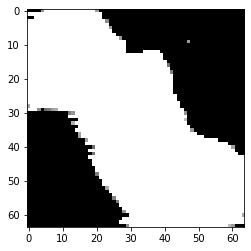

In [30]:
path = os.path.join(os.path.expanduser('~/'), 'data', 'salt')
with open (path+'/weights', 'rb') as fp:
    params = pickle.load(fp)  
fp.close()
Validate(train_images[0:1,:,:,:], train_labels[0:1,:,:,:], params, 1) #GN

Calculating Forward step . . .
Cost: 0.03   -   Accuracy: 96.59%


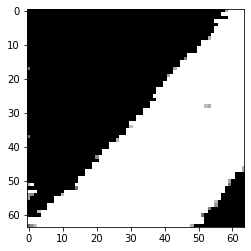

In [33]:
path = os.path.join(os.path.expanduser('~/'), 'data', 'salt')
with open (path+'/weights', 'rb') as fp:
    params = pickle.load(fp)  
fp.close()
Validate(train_images[1:2,:,:,:], train_labels[1:2,:,:,:], params, 1) #GN

Calculating Forward step . . .
Cost: 0.04   -   Accuracy: 96.19%


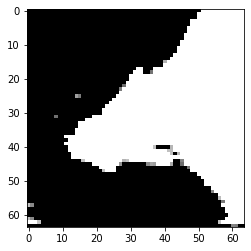

In [32]:
path = os.path.join(os.path.expanduser('~/'), 'data', 'salt')
with open (path+'/weights', 'rb') as fp:
    params = pickle.load(fp)  
fp.close()
Validate(train_images[2:3,:,:,:], train_labels[2:3,:,:,:], params, 1) #GN

In [ ]:
#Validate(test_images[1:2,:,:,:], test_labels[1:2,:,:,:], params_values);
Validate(test_images[0:1,:,:,:], test_labels[0:1,:,:,:], params, 1) #GN

Calculating Forward step . . .
Cost: 0.29   -   Accuracy: 75.01%


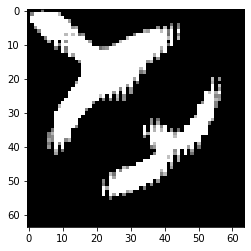

In [26]:
Validate(test_images[1:2,:,:,:], test_labels[1:2,:,:,:], params, 1) #GN

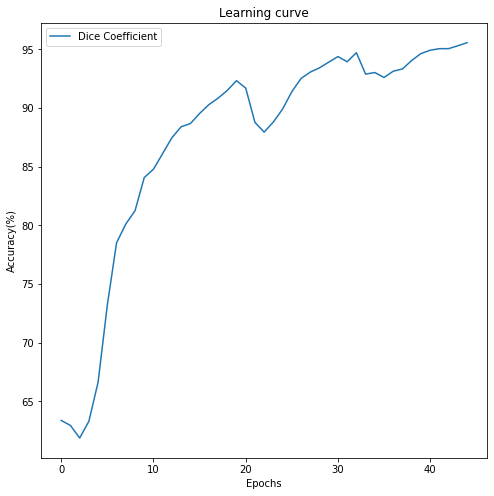

In [29]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(accuracy_history[:45], label="Dice Coefficient")
#plt.plot(accuracy_history2, label="Pixel-Wise CE")
#plt.plot(results.history["val_loss"], label="val_loss")
#plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy(%)")
plt.legend();

In [5]:
import pickle
import os
## read and extrada data from file
path = os.path.join(os.path.expanduser('~/'), 'data', 'salt')
with open (path+'/weights', 'rb') as fp:
    params = pickle.load(fp)  
fp.close()
### Unpacking ###
[filters, bias, f_dc, out_fb, GN_params] = params
[ga, be,_,_] = GN_params

[f1,f2,f3,f4,f5,f6,f7,f8,f9] = filters
[b1,b2,b3,b4,b5,b6,b7,b8,b9]= bias 
[fb6_dc, fb7_dc, fb8_dc, fb9_dc] = f_dc
[out_f, out_b] = out_fb

#List --> Numpy
filters = np.array(filters)
bias = np.array(bias)
f_dc = np.array(f_dc)
out_f = np.array(out_f)
out_b = np.array(out_b)
ga=np.array(ga)
be = np.array(be)


#################
#Validate(train_images[2:3,:,:,:], train_labels[2:3,:,:,:], params, 1)

## Now encode the info to a different binary file
path = os.path.join(os.path.expanduser('~/'), 'data', 'salt')

from array import array
output_file = open(path+'/weights_encrypted.bin', 'wb')

for i in range(9):# 9*2 filters
    float_array = array('f', filters[i][0].flatten())# f#_1
    float_array.tofile(output_file)
    float_array = array('f', filters[i][1].flatten())# f#_2
    float_array.tofile(output_file)
float_array = array('f', out_f.flatten())#out_f
float_array.tofile(output_file)
## save bias
for i in range(9):# 9*2 bias
    float_array = array('f', bias[i][0].flatten()) #b#_1
    float_array.tofile(output_file)
    float_array = array('f', bias[i][1].flatten()) #b#_2
    float_array.tofile(output_file)
float_array = array('f', out_b.flatten()) #out_b 
float_array.tofile(output_file)
#save fb_dc
for i in range(4):
    float_array = array('f', f_dc[i][0].flatten())# 4 dc filters
    float_array.tofile(output_file)
for i in range(4):
    float_array = array('f', f_dc[i][1].flatten())# 4 dc bias
    float_array.tofile(output_file)

for i in range(9): #9*2 gamma
    float_array = array('f', ga[i][0].flatten()) #ga#_1  ,shape: b.shape[0]//2
    float_array.tofile(output_file)   
    float_array = array('f', ga[i][1].flatten()) #ga#_1
    float_array.tofile(output_file) 
for i in range(9): #9*2 beta
    float_array = array('f', be[i][0].flatten()) #be#_1  ,shape: b.shape[0]//2
    float_array.tofile(output_file)   
    float_array = array('f', be[i][1].flatten()) #be#_1
    float_array.tofile(output_file)     
#close file
output_file.close()


In [ ]:

def resize(path=None):

    if path is None:
        # Set path to /home/USER/data/mnist or C:\Users\USER\data\salt
        path = os.path.join(os.path.expanduser('~/'), 'data', 'salt2')
    ####### TARGET DIMENSIONS ########
    target_dim=128                  
    ##################################
    def resize_images(path, target_dim):
        """Return images loaded locally."""
        folder = path + "/images/"
        dest_folder =path + "/images_resized/"
        for f in os.listdir(folder):
            cv2.imwrite(dest_folder+f, cv2.resize(cv2.imread(folder+f, cv2.IMREAD_GRAYSCALE),(target_dim, target_dim)))

    def resize_labels(path, target_dim):
        """Return labels loaded locally."""
        folder = path + "/labels/"
        dest_folder =path + "/labels_resized/"
        for f in os.listdir(folder):
            cv2.imwrite(dest_folder+f, cv2.resize(cv2.imread(folder+f, cv2.IMREAD_GRAYSCALE),(target_dim, target_dim)))



    print("Train Images : Loading . . .")
    resize_images(path,target_dim)
    print("Train Labels : Loading . . .")
    resize_labels(path,target_dim)
    #print("Test Images  : Loading . . .")
    #test_images = _t_images(path,dim)
    #print("Test Labels  : Loading . . .")
    #test_labels = _t_labels(path,dim)
    print("Done!")
    return # , test_images, test_labels
resize()